### CÁC THƯ VIỆN SỬ DỤNG

In [ ]:
import numpy as np
import pandas as pd 
import os
from keras.preprocessing.image import load_img
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast

### ĐỌC THƯ MỤC CHỨA DỮ LIỆU ẢNH HUẤN LUYỆN

In [2]:
path_to_data = "D:\Contest\AIFace\data\mnt\md0\projects\sami-hackathon\private\data/"
files = os.listdir(path_to_data)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 27653
100013282.jpg


### QUAN SÁT DỮ LIỆU

In [3]:
path_to_label = "D:/Contest/AIFace/last_label.csv"
df = pd.read_csv(path_to_label)
ages = df['age'].tolist()
genders = df['gender'].tolist()

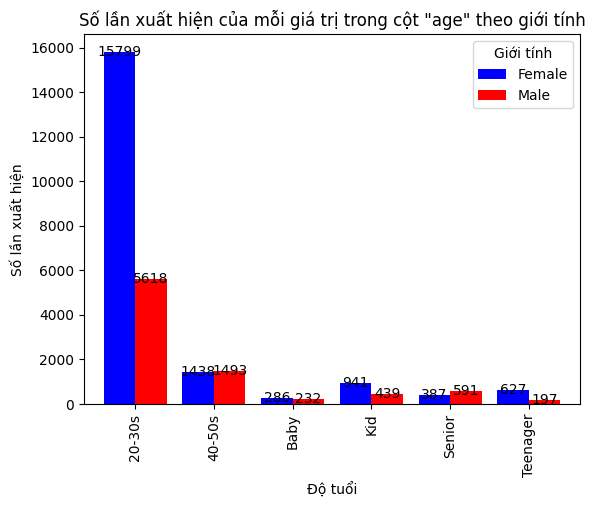

In [4]:
age_gender_counts = df.groupby(['age', 'gender']).size().unstack()

# Vẽ biểu đồ cột nhóm
ax = age_gender_counts.plot(kind='bar', color=['blue', 'red'], width=0.8)

# Đặt chú thích cho mỗi cột
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height + 0.1, int(height), ha='center', va='center', color='black')

# Tùy chỉnh đồ thị
plt.title('Số lần xuất hiện của mỗi giá trị trong cột "age" theo giới tính')
plt.xlabel('Độ tuổi')
plt.ylabel('Số lần xuất hiện')
plt.legend(title='Giới tính', loc='upper right')
plt.show()

### RÚT TRÍCH CÁC ĐẶC TRƯNG CỦA ẢNH

In [5]:
def extract_features(images, bboxs, indexs):
  features = []
  for row, image in tqdm(enumerate(images), total=len(images)):
    img = load_img(image, grayscale=True)
    bbox = bboxs[indexs[row]]
    bbox = ast.literal_eval(bbox)
    img = img.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
    img = img.resize((64, 64))
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  # Ignore this stop if using RGB
  features = features.reshape(len(features), 64, 64, 1)
  return features

In [6]:
X = extract_features(path_to_data + df['file_name'], df['bbox'], df.index)

  0%|          | 0/28048 [00:00<?, ?it/s]

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [7]:
X = X/255.0

### KHỞI TẠO BỘ HUẤN LUYỆN VÀ KIỂM THỬ

In [8]:
age_map = {'20-30s': 3, '40-50s': 4, 'Kid': 1, 'Senior': 5, 'Teenager': 2, 'Baby': 0}

In [9]:
from keras.utils import to_categorical
# Apply mapping to 'age' column
y_age = np.vstack(df['age'].apply(lambda x: age_map[x]).values).astype(np.float64)
y_age = to_categorical(y_age, num_classes=6)

In [10]:
# Assuming target_age and target_gender are numpy arrays
target_age = np.array(y_age)

# Split the data
x_train, x_test, y_train_age, y_test_age = train_test_split(
    X, target_age, test_size=0.2, shuffle=True
)
# Check the shapes after splitting
print("Training Samples:", x_train.shape[0])
print("Testing Samples:", x_test.shape[0])

Training Samples: 22438
Testing Samples: 5610


In [11]:
print("Shape of image:",X.shape)

Shape of image: (28048, 64, 64, 1)


### XÂY DỰNG MÔ HÌNH

In [12]:
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras.initializers import he_uniform
from keras.constraints import MaxNorm

In [13]:
# Create a Sequential model
model_age = Sequential()

# Convolutional layers with separable convolutions
model_age.add(SeparableConv2D(32, (3, 3), activation='relu', kernel_initializer=he_uniform(), kernel_constraint=MaxNorm(3), input_shape=(64, 64, 1)))
model_age.add(MaxPooling2D((2, 2)))
model_age.add(SpatialDropout2D(0.25))

model_age.add(SeparableConv2D(64, (3, 3), activation='relu', kernel_initializer=he_uniform(), kernel_constraint=MaxNorm(3)))
model_age.add(MaxPooling2D((2, 2)))
model_age.add(SpatialDropout2D(0.25))

# Flatten and fully connected layers for classification
model_age.add(Flatten())
model_age.add(Dense(128, activation='relu', kernel_initializer=he_uniform(), kernel_constraint=MaxNorm(3)))
model_age.add(Dense(6, activation='softmax'))  # Age group prediction (multiclass classification)

# Compile the model with an appropriate optimizer, loss function, and metrics for your task.
model_age.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### QUAN SÁT MÔ HÌNH

In [14]:
model_age.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separabl  (None, 62, 62, 32)        73        
 eConv2D)                                                        
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 spatial_dropout2d (Spatial  (None, 31, 31, 32)        0         
 Dropout2D)                                                      
                                                                 
 separable_conv2d_1 (Separa  (None, 29, 29, 64)        2400      
 bleConv2D)                                                      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0

### HUẤN LUYỆN MÔ HÌNH

In [15]:
# Train the model with your data.
h2 = model_age.fit(
    x_train,
    y_train_age,
    validation_data=(x_test, y_test_age),
    epochs=25,
    batch_size=128,
    shuffle=True
)

Epoch 1/25


176/176 [==============================] - 36s 197ms/step - loss: 0.8788 - accuracy: 0.7591 - val_loss: 0.7882 - val_accuracy: 0.7681
Epoch 2/25
176/176 [==============================] - 33s 187ms/step - loss: 0.7954 - accuracy: 0.7624 - val_loss: 0.7746 - val_accuracy: 0.7684
Epoch 3/25
176/176 [==============================] - 31s 176ms/step - loss: 0.7767 - accuracy: 0.7635 - val_loss: 0.7440 - val_accuracy: 0.7724
Epoch 4/25
176/176 [==============================] - 30s 173ms/step - loss: 0.7603 - accuracy: 0.7658 - val_loss: 0.7394 - val_accuracy: 0.7766
Epoch 5/25
176/176 [==============================] - 31s 177ms/step - loss: 0.7441 - accuracy: 0.7686 - val_loss: 0.7291 - val_accuracy: 0.7756
Epoch 6/25
176/176 [==============================] - 31s 176ms/step - loss: 0.7323 - accuracy: 0.7724 - val_loss: 0.7240 - val_accuracy: 0.7843
Epoch 7/25
176/176 [==============================] - 33s 185ms/step - loss: 0.7156 - accuracy: 0.7740 - val_loss: 0.7038 - val_

### LƯU MÔ HÌNH

In [16]:
model_age.save('model_age.h5')

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### KẾT QUẢ MÔ HÌNH

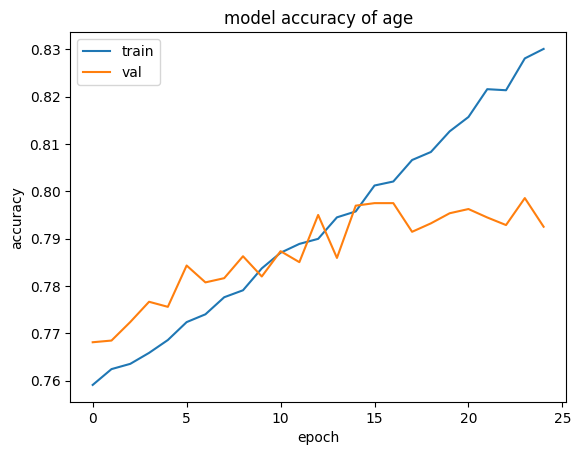

In [17]:
history = h2
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of age')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

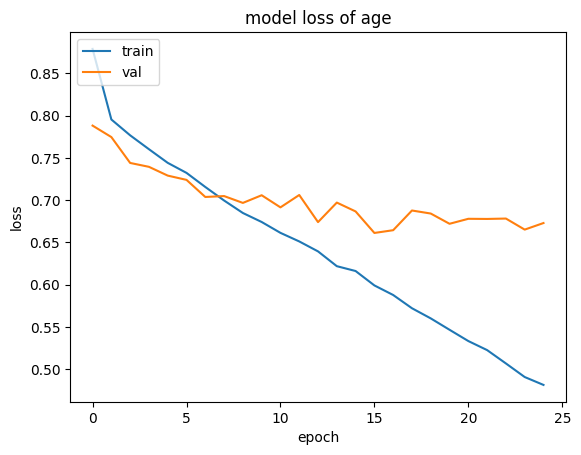

In [18]:
history = h2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss of age')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()